# Word2Vec

**This is an Educational Notebook that teaches Word2Vec internal with documenation**

In [4]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List

# Step 1 - Text Preprocessing

**A simple corpus is tokenized into induvidual words**

In [5]:
corpus = """
    In machine learning, word embedding are a type of word representation.
    that allows words to be represented as a vectors in a continous vector space.
    Word embeddings are low dimensional floating point vectors.
    The position of a word in the embedding space is learned from text and is based on the words that surround the word when it is used.
    Word embeddings are calculated using an algorithm like Word2Vec.
    Once calculated, word embeddings can be used as inputs to machine learning models.
    Word embeddings can also be used to calculate things like word similarity.
""".lower().split()

In [7]:
len(corpus)

94

In [8]:
# Building vocabulary from the corpus
vocab = list(set(corpus))
vocab_size = len(vocab)
print(vocab_size)

58


In [9]:
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}

In [ ]:
# Creating a skip-gram training data: (center_word, context_word) pairs
window_size = 2
data = []

for i, word in enumerate(corpus):
    for j in range(max(i - window_size, 0), min(i + window_size + 1, len(corpus))):
        if j != i:
            data.append((word, corpus[j]))

In [11]:
# Helper functions for one-hot encoding
def one_hot(idx, size):
    vec = np.zeros(size)
    vec[idx] = 1
    return vec

# Step 2 - Model Definition

**Initializing embedding matrices**

In [12]:
embedding_dim = 10
W1 = np.random.randn(vocab_size, embedding_dim) # input embedding
W2 = np.random.randn(embedding_dim, vocab_size) # output embedding

# Step 3 - Activation & Loss Function

*Sigmoid activation for binary classification*
>$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Softmax activation for multiclass context-prediction
>$$
\sigma(x_i) = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}}
$$

so both of these *Activation functions are used directly*

Negative sampling loss
>$$
L = - \log \sigma(u_o^T v_c) - \sum_{k \in K} \log \sigma(-u_k^T v_c)
$$

In [14]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Negative sampling loss function
def get_negative_samples(
    pos_idx,
    num_neg  
):
    
    neg_samples = []
    while len(neg_samples) < num_neg:
        neg = random.randint(0, vocab_size - 1)
        if neg != pos_idx:
            neg_samples.append(neg)
            
    return neg_samples

# Step 4 - Training Loop

**Objective: Maximize the probability of context words given a center word**

*The loss is used is categorical cross-entropy:*

$$
L = -\sum_{k=1}^K \log P(w_k | w_{center})
$$

where $K$ is the context window size and $w_k$ is the $kth$ context word.

In [ ]:
learning_rate = 0.01
epochs = 1000
losses = []

for epoch in range(epochs):
    total_loss = 0
    
    for target, context in data:
        target_idx = word2idx[target]
        context_idx = word2idx[context]
        
        # Step 1: Forward pass:
        v_t = W1[target_idx]  # Target word vector (embedding_dim, 1)
        score = np.dot(W2.T, v_t) # Raw score for all words (vocab_size, 1)
        y_pred = softmax(score) # probability distribution over vocabulary (vocab_size, 1)
        
        # Step 2: compute loss
        loss = -np.log(y_pred[context_idx])
        total_loss += loss
        
        # step 3: backward pass (gradients)
        # Gradient of loss w.r.t. score
        dl_score = y_pred.copy()
        dl_score[context_idx] -= 1 # Subtract 1 from the true context index
        
        # Gradient w.r.t W2 and W1
        dW2 = np.outer(v_t, dl_score) # (embedding_dim, vocab_size)
        dW1 = np.dot(W2, dl_score) # (embedding_dim,)
        
        # Step 4: update weights
        W1[target_idx] -= learning_rate * dW1
        W2 -= learning_rate * dW2
        
    losses.append(total_loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss}')

# Step 5 - Evaluation and Similarity

**Functions to retrieve embeddings and compute cosine similarity between them**

In [17]:
def get_embedding(word):
    return W1[word2idx[word]]

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def most_similar(word, top_n = 3):
    vec = get_embedding(word)
    sims = {}
    for w in vocab:
        if w != word:
            sims[w] = cosine_similarity(vec, get_embedding(w))
    
    return sorted(sims.items(), key = lambda x: x[1], reverse = True)[:top_n]

# Step 6 - Inferencing with word2vec

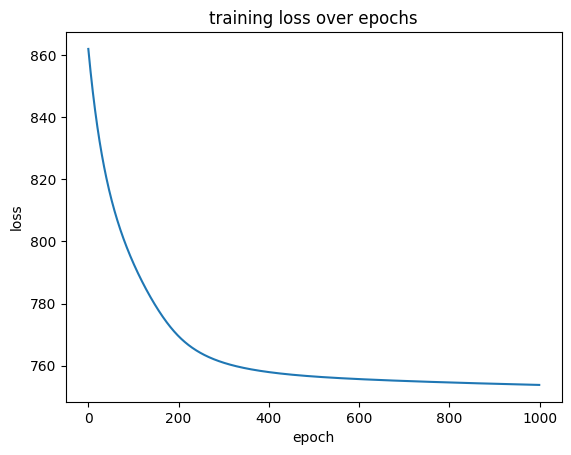

In [20]:
plt.plot(losses)
plt.title("training loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [21]:
print("Most similar to `WORD`:", most_similar("word"))

Most similar to `WORD`: [('type', np.float64(0.6007709264819177)), ('calculated', np.float64(0.5965159498874724)), ('used.', np.float64(0.5590907193381861))]
